# Bow data processing to extract cutting efficiency of a diamond wire

This package is used to calculate the cutting efficiency from bow data measured in-situ during diamond wire cutting of a silicon brick into wafers. The calculation consists of the following successive steps:
<br>
   - Conversion of the instrumental time of the bow measurement into the percentage of cut duration 
   - Bow data smoothing to get rid of the fluctuations related to the backward-and-forward wire motion 
   - Bow data downsampling to keep a reasonable number of measurements (about 150 points) 
   - Vertical force computation from the smoothed and downsamples bow data using equation 3 (publication ref)
   - Cutting efficiency computation from the computed vertical force using equation 4 (publication ref)
    
### Inputs
The processing requires at least:
<br>
- The following parameters:
          
  - cut_name: Reference of the experimental cut
  - time_to_contact (s): Experimental time to contact the silicon brick with wire web 
  - cut_effective_duration (min): Effective duration of the cut
  - sensors_nbr: Number of sensors used for the bow measurements
  - wire_guides_gap (mm): Distance of the wire guides to the brick
  - brick_width (mm): Width of the silicon brick to be cut
  - wire_tension (N): Tension applied to the wire
  - table_speed (mm/min): Speed of the brick downward motion 
  - wire_speed (m/s): Average absolute value of the wire speed
  <br>
- A data frame data with the following fields:
     
  - 'Time (s)'   : Instrumental time of measurement 
  - 'Bow # (mm)' : Bow measurement at sensor number #
 <br> 
 
 However the bow measurements may be in a specific format that should be converted to provide the above inputs
 
### Outputs
'Results_' + cut_name + '.xlsx', EXCEL file composed of 3 sheets:
<br>
 - Sheet "Bow": Smoothed and downsampled bow values (mm) vs percentage of cut duration
 - Sheet "Force": Computed vertical force (N) vs percentage of cut duration
 - Sheet "Kappa": Computed cutting efficiency (${\rm{10}}$${^{ - 7}}$ ${\rm{m.N}}$${^{ - 1}}$) vs percentage of cut duration
<br>     
     

# Specification of paths

In [1]:
# Main for this cell
# Version 2021/02/19
'''
Specification of paths depending of the OS and user
'''
# Standard library imports
import os
from pathlib import Path

# Specific to Jupyter
%matplotlib inline  

# Root directory for all files 
root = Path("C:/Users/franc/OneDrive/Bureau/confocal")
data_folder = Path("fichiers/publi INES") 
if not os.path.isdir(root) : 
    root = Path('/Users/amal/Documents/0- AC sur Mac/Coustier & al_extrait') 
    data_folder = "Fichiers EXEL corrigés"

# Path identification for data access and results saving
my_path= root / Path(data_folder)

print('Paths defined')

Paths defined


# Definition of internal functions for data configuration
- Bow_Kappa_files
- Param_extract
- Data_extact
- bow2kappa
- Kappa_3Dplot_values 
- Kappa_Wireframe 

In [2]:
def Bow_Kappa_files(cut_name, my_path):
    '''
    Version 2021.02.20
    Set file names for a cut
    
    Inputs
    - cut_name (string): identification of the cut (ex: "125" where 125 is the reference number of the cut)
    - my_path (pathlib.PosixPath): path for input and output files
    
    Outputs
    - input_file (pathlib.PosixPath): file name for reading the experimental data of the cut
    - output_file (pathlib.PosixPath): file name for saving the results related to the cut
    '''
    input_file_name = 'Bow_' + cut_name + '.xlsx'
    output_file_name = 'Results_' + cut_name + '.xlsx'
    input_file = my_path / input_file_name
    output_file = my_path / output_file_name
    
    return input_file,output_file


def Param_extract(file, sheet):
    '''
    Version 2021.02.20
    Extract the cutting parameters. 
    The parameters are listed in the sheet 'sheet' of the EXCEL file 'file'.  
    
    Inputs
    - file (pathlib.PosixPath): file name for reading the experimental data of the cut
    - sheet (string): name of the sheet containing the parameters in the EXCEL file 'file'
    
    Outputs
    - dparam (dictionary): from which cutting parameters values may be extracted using key "Value"  
 
    '''
    
    # 3rd party imports
    import pandas as pd

    # Get the values of the cutting parameters from the input file
    dparam = pd.read_excel(file,
                         sheet_name = sheet)
    
    return dparam

def Data_extract(file, sheet, sensors_nbr):
    '''
    Version 2021.02.20
    Extract the data listed in the sheet 'sheet' of the EXCEL file 'file'.  
    
    Inputs
    - file (pathlib.PosixPath): file name for reading the  data of the cut
    - sheet (string): name of the sheet containing the data in the EXCEL file 'file'
    - sensors_nbr (integer): number of sensors of which the data will be extracted
    
    Outputs
    - data (dictionary): data extracted from the EXCEL file 'file' using columns C up to G 
    depending on the number of sensors sensors_nbr vs cut progress (column B) expressed either in time 
    or in percentage of cut duration 
    '''

    # 3rd party imports
    import pandas as pd

    # Get the bow data from the input file
    kappa_cols = {
                 0: "B",
                 1: "C",
                 2: "D",
                 3: "E",
                 4: "F",
                 5: "G"    
                 }
    endcol=kappa_cols[sensors_nbr]
    usecols = 'B:'+ str(endcol)

    data = pd.read_excel(file,
                         sheet_name =sheet, 
                         usecols=usecols)
    
    return data 

def bow2kappa(data, dparam, output_file):
    
    '''
    Version 2021.02.20
    Data filering and downsampling
    Vertical force computation
    Cutting efficiency kappa computation
    Storage of the results in an excel file with three sheets:
         Bow with columns names:  'Cut progress (%)' 'Bow # (mm)'
         Force with columns names: 'Cut progress (%)' 'Force # (N)'
         Kappa with columns names: 'Cut progress (%)' 'Kappa # x10^7 (m/N)'
         
    Inputs
    - data (dictionnary): bow raw measurements 
    - dparam (dictionnary): from which cutting parameters values may be extracted using key "Value"
    - output_file (pathlib.PosixPath): file name for saving the results of the computations 
    
    outputs
    - dic_bow (dictionnary): bow data after smoothing and downsampling
    - dic_force (dictionnary): force data as calculated using dic_bow
    - dic_kappa (dictionnary): kappa data as calculated using dic_force
    '''

    # Standard library imports
    import os

    # 3rd party imports
    import numpy as np
    import pandas as pd
    from scipy import signal
    import openpyxl
    import matplotlib.pyplot as plt    

    # Excel writer to flush the results
    try:
        with open(output_file):
            os.remove(output_file)
            writer = pd.ExcelWriter(output_file, engine='openpyxl')
    except IOError:        
        writer = pd.ExcelWriter(output_file, engine='openpyxl')

    # Get useful parameters for bow conversion to cutting efficiency
    time_to_contact = np.array(dparam['Value'])[2]
    cut_effective_duration = np.array(dparam['Value'])[3]
    sensors_nbr = np.array(dparam['Value'])[4]
    sensor_init = np.array(dparam['Value'])[5]
    wire_guides_gap = np.array(dparam['Value'])[6]
    brick_width = np.array(dparam['Value'])[7]
    wire_tension = np.array(dparam['Value'])[8]
    table_speed = (np.array(dparam['Value'])[9])/(1000*60)
    wire_speed = np.array(dparam['Value'])[10]
    
    # conversion time --> cut percentage 
    per_cent_coupe = np.array(data['Time (s)'])
    time_init = per_cent_coupe[0]
    per_cent_coupe = 100 * (per_cent_coupe - time_init - time_to_contact) / (60*cut_effective_duration)

    # Smooth and downsample the data using a moving window of length long and of type win
    long = 121
    win ='boxcar'   #'triang'#'boxcar',  #'hamming', 'boxcar', 
                    #'boxcar','triang', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman',
    norme = sum(signal.get_window(win, long))
    dic_bow = {}
    bow_name = [x for x in data.columns if 'Bow' in x]
    for bow in bow_name:
        data_filter = data[bow].rolling(long,center=True, win_type=win, axis=0).sum()/norme
        dic_bow[bow] = data_filter[long//2+1::long]
    dic_bow['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new = pd.DataFrame.from_dict(dic_bow)
    new=new.reindex(columns= ['Cut progress (%)', *bow_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new.to_excel(writer, sheet_name='Bow')
    writer.save()
    writer.close()

    # Vertical force computation
    dic_force = {}
    force_name = [bow.replace('Bow','Force')[:-5] + ' (N)' for bow in bow_name] # Force columns names
    for force,bow in zip(force_name,bow_name):
        dic_force[force] = (4*wire_tension*np.array((dic_bow[bow]))) \
        /(2*wire_guides_gap+brick_width)
    dic_force['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new_force = pd.DataFrame.from_dict(dic_force)
    new_force = new_force.reindex(columns= ['Cut progress (%)', *force_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new_force.to_excel(writer, sheet_name='Force')
    writer.save()
    writer.close()

    # Cutting efficiency computation
    dic_kappa = {}
    kappa_name = [bow.replace('Bow','Kappa')[:-5] + ' x10^7 (m/N)' for bow in bow_name] # Kappa columns names
    for kappa, force in zip(kappa_name,force_name):  
        dic_kappa[kappa] = 10000000*(brick_width/1000)*table_speed \
        /(wire_speed*np.array((dic_force[force])))
    dic_kappa['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new_kappa = pd.DataFrame.from_dict(dic_kappa)
    new_kappa = new_kappa.reindex(columns= ['Cut progress (%)', *kappa_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new_kappa.to_excel(writer, sheet_name='Kappa')
    writer.save()
    writer.close()
    
    return dic_bow,dic_force,dic_kappa

def Kappa_3Dplot_values(dkappa,val_min, val_max,z_min,z_max,sensors_nbr): 
    
    '''
    Version 2021.02.10
    Arrangement of the cutting efficiency calculated from the bow in-situ measurements
    by bow2kappa function for a wireframe 3D plot
    
    Inputs
    - output_file: name of the results file (output of bow2kappa function)
    - val_min, val_max : minimum and maximum values of the cut progress range 
      used for data selection and xaxis in the 3D plot
    - z_min, z_max: minimum and maximum values of the cutting efficiency range 
      used for zaxis in the 3D plot
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    
    Outputs
    - 3D plot of the cutting efficiency values 
    '''
    
    # 3rd party imports
    import numpy as np
    import pandas as pd
    from scipy import interpolate

    # Select cut progress range and build x,y,z values distribution suitable for the 3D plot
    dkappa.rename({"Cut progress (%)":"A"}, axis=1, inplace=True) # Rename colonne for query attribute use
    df= dkappa.query('A > @val_min and A < @val_max') 
    u = [i for i in range(1,sensors_nbr+1)] # Sensor number 
    v = list(df['A'])                       # % of cut 
    cut_progress_nb= len(v)                 # Number of cut progress values
    df=df.drop(['A'],axis=1)                # Keep only z values in df
    z = df.values                           # 2D array of z values

    # z calculation at interpolated values of u,v  
        # Definition of 2D linear interpolation function
    newfunc = interpolate.interp2d(u,v,z,kind='linear')
        # New sampling of 1000 points along x between extrema of x1
    unew = np.linspace(u[0] , u[-1], num=1000, endpoint=True)
        # New sampling of 1000 points along y between extrema of y1
    vnew = np.linspace(v[0] , v[-1], num=1000, endpoint=True)
        # Use of the defined newfunc as 2D linear interpolation
        # (x,y) mesh re-construction for the (xnew,ynew) positions
    y,x = np.meshgrid(unew, vnew)     
        # for the calculation of z at the (xnew,ynew) positions 
    znew = newfunc(unew, vnew)        

    return x, y, znew, cut_progress_nb

def Kappa_Wireframe(x, y, z, z_min, z_max, sensors_nbr, cut_progress_nb, ax): 

    '''
    Version 2021.02.10
    Wireframe 3D plot configuration of the cutting efficiency values 
    as function of the cut progress and the sensor number
    
    Inputs
    - x:  1D array of the interpolated values of the cut progress for the wireframe 3D plot 
      as arranged by Kappa_3Dplot_values function
    - y:  1D array of the interpolated values of the sensor number for the wireframe 3D plot 
      as arranged by Kappa_3Dplot_values function  
    - z: 2D array of cutting efficiency as arranged by Kappa_3Dplot_values function
    - z_min, z_max: minimum and maximum values of z range 
      used for zaxis in the 3D plot
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    - cut_progress_nb: number of cut progress sampling points (parameter of the cut)
    - ax: figure subplot description
    
    Outputs
    - configuration of z values as function of x and y for a wireframe 3D plot  
    '''    

    # 3rd party imports
    import matplotlib.pyplot as plt
    
    # Set plot parameters
    ticks_size = 10  # fontsize of ticks labels 
    label_size = 12  # fontsize of axes labels
    line_space = 2   # line spacing between ticks labels and axe label
    x0 = [10,20,30,40,50,60,70,80]                  # xticklabels
    y0 = [i for i in range(1,sensors_nbr+1)]        # yticklabels 
    z_min_rnd,z_max_rnd,z_step_nbr= int(round(z_min)),int(round(z_max)),1
    z0=[i for i in range(z_min_rnd+1,z_max_rnd+1)]  # yticklabels 
    thickness = 0.4  # Line thickness of the 3D plot curves 
    plot_azim = 40   # 3D plot azimut
    plot_elev = 5    # 3D plot elevation 
    
    # Set a wireframe 3D plot
    surf=ax.plot_wireframe(x, y, z, thickness, rcount=cut_progress_nb, \
                           ccount=sensors_nbr-1, color='red')  
      
    # Set plot title
    ax.set_title(f'Cut {cut_name}', fontsize = label_size) 
    # Set point of view of 3D plot
    ax.view_init(elev=plot_elev, azim=plot_azim)           
    
    # Set x axe   
    ax.set_xticks(x0, minor=False)
    ax.set_xticklabels(x0, fontsize=ticks_size)
    ax.set_xlabel('\nCut progress (%)', linespacing=line_space, fontsize=label_size) 
    
    # Set y axe    
    ax.set_yticks(y0, minor=False)          # set ticks label for y axis (integer values)
    ax.set_yticklabels(y0, fontsize=ticks_size)
    ax.set_ylabel('\nSensor number', linespacing=line_space, fontsize=label_size) 
    
    # Set z axe 
    ax.set_zlim(z_min, z_max)   # set limits of z axis 
    ax.set_zticks(z0, minor=False)
    ax.set_zticklabels(z0, fontsize=ticks_size)    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel('Cutting efficiency (10$^{-7}$ m.N$^{-1}$)', \
                  rotation=90, fontsize=label_size) 
    
# Main of this cell
print('Functions defined for data building:')
print('- Bow_Kappa_files')
print('- Param_extract')
print('- Data_extact')
print('- bow2kappa')
print('- Kappa_3Dplot_values') 
print('- Kappa_Wireframe') 


Functions defined for data building:
- Bow_Kappa_files
- Param_extract
- Data_extact
- bow2kappa
- Kappa_3Dplot_values
- Kappa_Wireframe


# Batch plot of bow 
## For a set of cuts that may be limited to one cut
The following cell uses the internal functions:
- Bow_Kappa_files
- Param_extract
- Data_extract
<br>
<br>

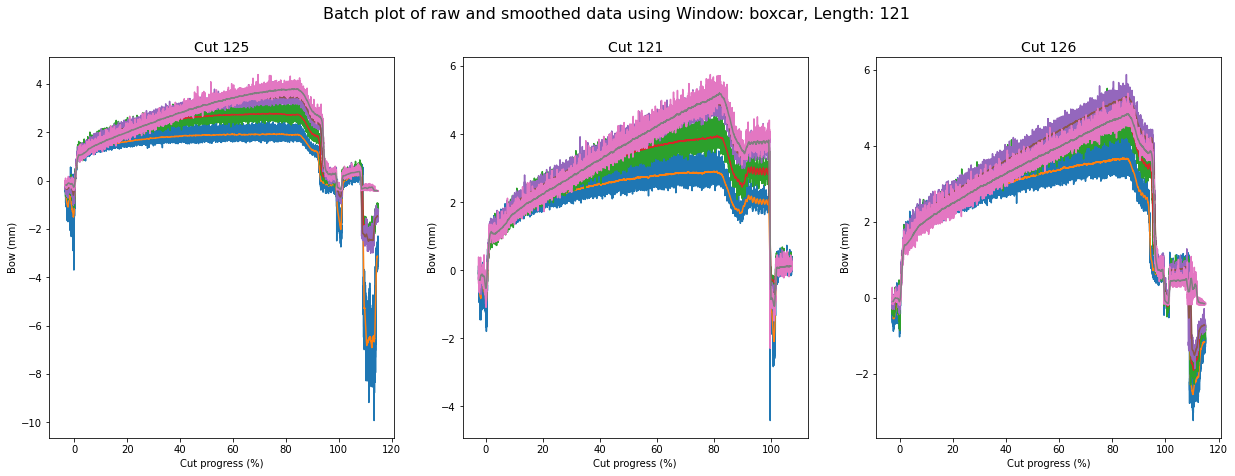

In [3]:
# Version 2021.02.20
# Batch plot of raw and smoothed data of the measured bow for a set of cuts 
# The data from the common sensors used by the set of cuts are plotted on the same graph for each cut
# on the whole cut duration
# Set of cuts may be limited to 1 cut

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal 

# Data set identification
cuts = ["125","121","126"] 

# Set of smoothing and downsampling parameters
long = 121
win ='boxcar'   #'triang', 'boxcar', 'hamming', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman'
norme = sum(signal.get_window(win, long))

# Set the plot range for the bow data in mm
bow_min, bow_max = 1, 6.5

# Set figure parameters for batch plot
fig = plt.figure(figsize=(7*len(cuts),7))   # Plot area 
gs = gridspec.GridSpec(1, len(cuts))
fig.suptitle(f'Batch plot of raw and smoothed data using Window: {win}, Length: {long}\n', \
             fontsize = 16)

# Set useful sheet names
sheet_params = "Params"
sheet_data = "Raw data"
        
# Set list of file names and parameters for each cut
bow_file_list, kappa_file_list, dparam_list, sensors_nbr_list = [], [], [], []
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = Bow_Kappa_files(cut_name, my_path)
    bow_file_list.append(bow_file_cut)
    kappa_file_list.append(kappa_file_cut)
    
    dparam_cut = Param_extract(bow_file_cut, sheet_params)
    sensors_nbr_cut = np.array(dparam_cut['Value'])[4]
    dparam_list.append(dparam_cut)
    sensors_nbr_list.append(sensors_nbr_cut)

# Identify the number of common sensors to the set of cuts
sensors_nbr = min(sensors_nbr_list)    

# Batch plot of the cuts
i_cut = 0 # initialization on the cut index
i_ax = 0  # initialization on the ax index
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = str(bow_file_list[i_cut]), str(kappa_file_list[i_cut])
    dparam_cut = dparam_list[i_cut]
    dbow = Data_extract(bow_file_cut, sheet_data, sensors_nbr)
    
    # Get useful parameters for time conversion to cut progress ratio
    time_to_contact = np.array(dparam_cut['Value'])[2]
    cut_effective_duration = np.array(dparam_cut['Value'])[3]
    
    # Conversion  of time to cut progress ratio 
    per_cent_coupe = np.array(dbow['Time (s)'])
    time_init = per_cent_coupe[0]
    per_cent_coupe = 100 * (per_cent_coupe - time_init - time_to_contact) / (60*cut_effective_duration)

    # Smooth, downsample and plot the data using a moving window of length long and of type win
    dic_bow = {}
    bow_name = [x for x in dbow.columns if 'Bow' in x]
    ax=fig.add_subplot(gs[0,i_ax])
    for bow in bow_name:
        data_filter = dbow[bow].rolling(long,center=True, win_type=win, axis=0).sum()/norme
        ax.plot(per_cent_coupe,dbow[bow])
        ax.plot(per_cent_coupe,data_filter)
                          
    ax.set_xlabel('Cut progress (%)')
    ax.set_ylabel('Bow (mm)')
    ax.set_title(f'Cut {cut_name}', fontsize = 14)
    
    i_ax=i_ax+1
    i_cut=i_cut+1
                       
plt.show()


# Batch 3D plot of cutting efficiency 
## For a set of cuts that may be limited to one cut
The following cell uses the internal functions:
- Bow_Kappa_files
- Param_extract
- Data_extract
- bow2kappa
- Kappa_3Dplot_values
- Kappa_Wireframe
<br>
<br>

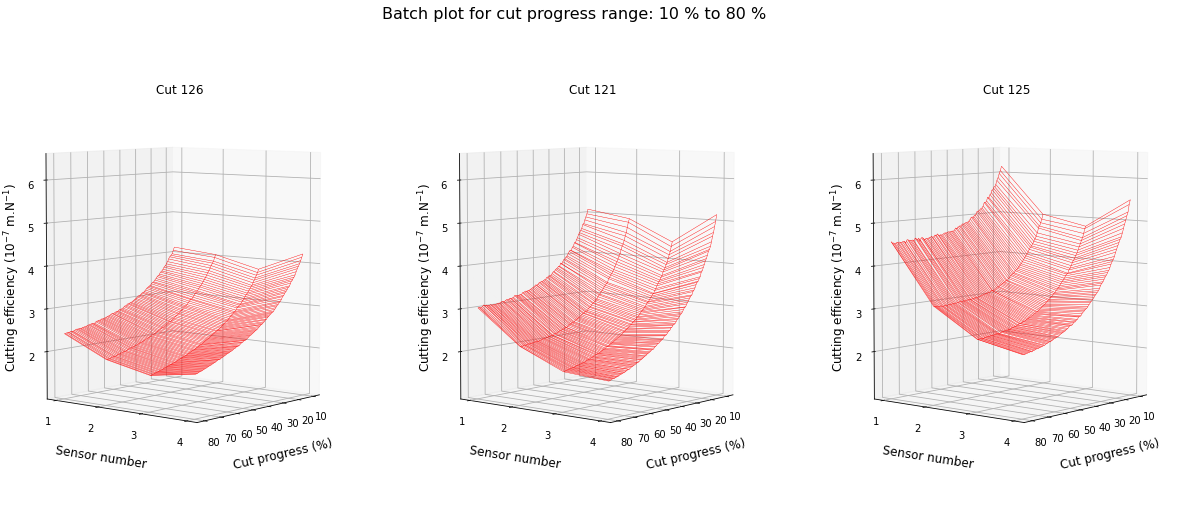

In [4]:
# Version 2021.02.20
# Batch 3D plot of cutting efficiency data calculated from the measured bow for a set of cuts 
# The data from the common sensors used by the set of cuts are plotted on a 3D graph for each cut
# on the specified cut duration
# Set of cuts may be limited to 1 cut

# 3rd party imports
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Data set identification
cuts = ["126","121","125"] 

# Set the plot range for the cutting progress in % of cut duration
cut_min, cut_max = 10, 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set figure parameters
fig = plt.figure(figsize=(7*len(cuts),8))   # Plot area 
gs = gridspec.GridSpec(1, len(cuts))
fig.suptitle(f'Batch plot for cut progress range: {cut_min} % to {cut_max} %', fontsize = 16)

# Set useful sheet names
sheet_params = "Params"
sheet_data = "Raw data"
sheet_kappa = "Kappa"

# Set file names, parameters and sensors number for batch plot
bow_file_list, kappa_file_list, dparam_list, sensors_nbr_list = [], [], [], []
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = Bow_Kappa_files(cut_name, my_path)
    bow_file_list.append(bow_file_cut)
    kappa_file_list.append(kappa_file_cut)
    
    dparam_cut = Param_extract(bow_file_cut, sheet_params)
    sensors_nbr_cut = np.array(dparam_cut['Value'])[4]
    dparam_list.append(dparam_cut)
    sensors_nbr_list.append(sensors_nbr_cut)

# Identify the number of common sensors to the set of cuts
sensors_nbr = min(sensors_nbr_list)    

# Batch wireframe 3D plot of the cuts
i_cut = 0 # initialization on the cut index
i_ax = 0  # initialization on the ax index
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = str(bow_file_list[i_cut]), str(kappa_file_list[i_cut])
    dparam_cut = dparam_list[i_cut]
    
    try:         
        dkappa_cut = Data_extract(kappa_file_cut, sheet_kappa, sensors_nbr)
    except: 
        dbow_cut = Data_extract(bow_file_cut, sheet_data, sensors_nbr)
        _= bow2kappa(dbow_cut, dparam_cut, kappa_file_cut)
        dkappa_cut = Data_extract(kappa_file_cut, sheet_kappa, sensors_nbr)
    
    x,y,z,cut_progress_nb = Kappa_3Dplot_values(dkappa_cut, cut_min, cut_max,\
                                                    eff_min, eff_max, sensors_nbr)
    
    # Plotting the wireframe 3D plot
    ax=fig.add_subplot(gs[0,i_ax], projection='3d') # Frame for 3D plot 
    Kappa_Wireframe(x, y, z, eff_min, eff_max, sensors_nbr, cut_progress_nb, ax)
    
    i_ax=i_ax+1
    i_cut=i_cut+1
    
plt.show()

# 2020.02/20: All cells bellow are under revision but can be tested  

#  Single cut 3D plot and statistical analysis
The following cell defines the internal functions:
- Kappa_data
- Kappa_flatten
- Kappa_hist
- Kappa_bbox
<br>
<br>
Please check the version and use the last one

In [5]:
# Definition of useful functions for statistical analysis
# Version 2021.02.19
# - Kappa_data
# - Kappa_flatten
# - Kappa_hist
# - Kappa_bbox

def Kappa_data(dk, val_min, val_max, sensors_nbr): 
    
    '''
    Version 2021.02.13
    Define a dictionary containing the cutting efficiency data calculated from the bow in-situ measurements
    by bow2kappa function on a specific cut-progress range
    
    Inputs
    - data_file: name of the results file (output of bow2kappa function)
    - val_min, val_max : minimum and maximum values of the cut-progress range 
      used for data selection 
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    
    Outputs
    - Dictionary dkappa for plot and statistical analysis
    '''
    
    # 3rd party imports
    import copy
    
    # Select cut-progress range
    dk.rename({"Cut progress (%)":"A"}, axis=1, inplace=True)
    dk_part = dk.query('A > @val_min and A < @val_max')
    dkappa = copy.deepcopy(dk_part)
    dkappa.rename({"A":"Cut progress (%)"}, axis=1, inplace=True)
    
    return dkappa


def Kappa_flatten(kappa_file, val_min, val_max, sensors_nbr, sensor_init, sensor, sheet_kappa):
    
    '''
    Version 2021.02.19
    Flattening of data for statistical analysis of the cutting efficiency calculated 
    from the bow in-situ measurements by bow2kappa function
    
    Inputs
    - kappa_file: name of the results file (output of bow2kappa function)         
    - val_min, val_max: minimum and maximum values of the cut-progress range 
                        used for plot title label
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    - sensor_init: label of the first sensor of the sensors
    - sensor: index of the sensor of which the data are analyzed among the sensors used for the measurements
    
    Called functions 
     - Kappa_data: build dkappa dictionary of the cutting efficiency data calculated from the bow in-situ measurements 
              by bow2kappa function on the specified cut-progress range 
    
    Outputs
    - dkappa_flatten: flattened dkappa dictionary  
              
    '''
  
    # Selection of data 
    dk = Data_extract(kappa_file, sheet_kappa, sensors_nbr)
    dkappa = Kappa_data(dk, val_min, val_max, sensors_nbr)
    dkappa = dkappa.drop(["Cut progress (%)"],axis=1)
    
    if sensor != 0:
        sensors = []
        for s in range(sensors_nbr):
            sensors.append(s)
        for s in sensors:
            if s != sensor-1 :
                dkappa = dkappa.drop(["Kappa " + str(sensor_init + s) + " x10^7 (m/N)"],axis=1)
            
    # dkappa flattening
    dkappa_flatten = dkappa.values.flatten()

    return dkappa_flatten

def Kappa_hist(dkappa_flat, x_min, x_max): 
    
    '''
    Version 2021.02.19
    Statistical analysis of the cutting efficiency calculated from the bow in-situ measurements
    by bow2kappa function
    
    Inputs
    - dkappa_flat: dictionary containing the cutting efficiency data to be analysed           
    - x_min, x_max: minimum and maximum values of the cutting efficiency range 
                    used for the histogram plot 
    
    Outputs
    - Histogram plot of the cutting efficiency values
    '''
    
    # 3rd party imports
    import numpy as np
    import matplotlib.pyplot as plt
  
    # Histogram plot 
    plt.hist(dkappa_flat,bins=25)
    plt.xlim(x_min,x_max)
    plt.xlabel('Cutting efficiency (10$^{-7}$ m.N$^{-1}$)',fontsize=12)  
    
def Kappa_bbox(dkappa_flat, x_min, x_max): 
    
    '''
    Version 2021.02.19
    Statistical analysis of the cutting efficiency calculated from the bow in-situ measurements
    by bow2kappa function
    
    Inputs
    - dkappa_flat: dictionary containing the cutting efficiency data to be analysed           
    - x_min, x_max: minimum and maximum values of the cutting efficiency range 
                    used for the boxplot plot 
   
    Outputs
    - Histogram plot of the cutting efficiency values
    - Box plot of the cutting efficiency values
    '''
    
    # 3rd party imports
    import numpy as np
    import matplotlib.pyplot as plt 
       
    # Boxplot plot
    plt.boxplot(dkappa_flat)
    
    plt.ylim(x_min,x_max)

print('Functions Kappa_flatten, Kappa_hist and Kappa_bbox for statistical analysis defined')

Functions Kappa_flatten, Kappa_hist and Kappa_bbox for statistical analysis defined


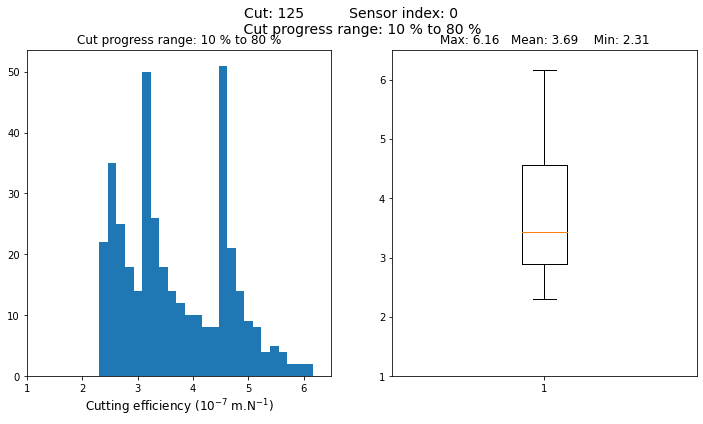

In [26]:
# Main for histogram plot and boxplot of data of a single sensor or of data from all sensors
# Version 2021.02.20

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt 

# Data set identification
cut_name = "125"

# Set useful sheet names
sheet_params = "Params"
sheet_kappa = "Kappa"

# Set file names and parameters of kappa data
bow_file, kappa_file= Bow_Kappa_files(cut_name, my_path)
dparam = Param_extract(bow_file, sheet_params)
sensors_nbr = np.array(dparam['Value'])[4]
sensor_init = np.array(dparam['Value'])[5]

# Set de sensors data skipped from the analysis
sensor = 0      # =< sensors_nbr; number of the sensor of which data will be kept for the analysis
                # If sensor = 0, data of all sensors will be kept for the analysis 

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 70  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max

    # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function
    dkappa_flatten = Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)

    # Figure settings
    fig = plt.figure(figsize=(12,6))

    # Subplot settings for histogram plot
    plt.subplot(1,2,1)
    plt.suptitle(f'Cut: {cut_name}          Sensor index: {sensor}\n \
    Cut progress range: {cut_min_interv} % to {cut_max_interv} %',fontsize=14)
                 
    # Plot the histogram of cutting efficency data using Kappa_hist function
    plt.title(f'Cut progress range: {cut_min_interv} % to {cut_max_interv} %')
    Kappa_hist(dkappa_flatten, eff_min, eff_max)    
    
    # Subplot settings for boxplot plot
    plt.subplot(1,2,2)

    # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
    # Statistics computation
    k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
    k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
    k_min = "{:5.2f}".format(np.min(dkappa_flatten))
    plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
    Kappa_bbox(dkappa_flatten, eff_min, eff_max)
    
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should lower than ' + str(num_max))

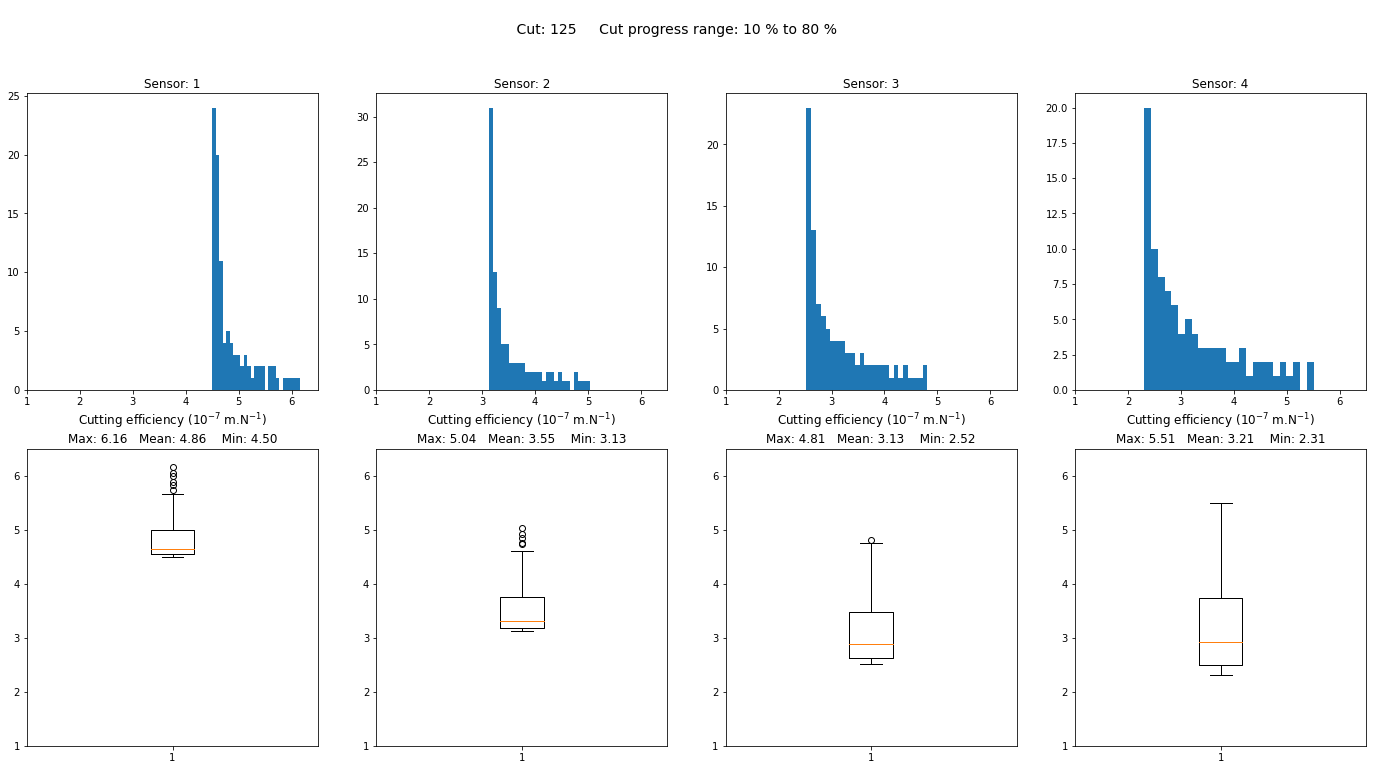

In [27]:
# Main for batch histogram plot and boxplot of each-sensors data of a single cut
# Version 2021.02.20

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt 

# Data set identification
cut_name = "125"

# Set useful sheet names
sheet_params = "Params"
sheet_kappa = "Kappa"

# Set file names and parameters of kappa data
bow_file, kappa_file= Bow_Kappa_files(cut_name, my_path)
dparam = Param_extract(bow_file, sheet_params)
sensors_nbr = np.array(dparam['Value'])[4]
sensor_init = np.array(dparam['Value'])[5]

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 70  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max
    
    # Figure settings
    nb_col = 6 * sensors_nbr
    nb_lin = 6 * 2
    fig = plt.figure(figsize=(nb_col,nb_lin))
    plt.suptitle(f'\n Cut: {cut_name}     Cut progress range: {cut_min_interv} % to {cut_max_interv} %',fontsize=14) 
    
    for sensor in range(1,sensors_nbr + 1):
        
        # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function
        dkappa_flatten = Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)

        # Subplot settings for histogram plot
        plt.subplot(2,sensors_nbr,sensor)
        
                 
        # Plot the histogram of cutting efficency data using Kappa_hist function
        plt.title(f'Sensor: {sensor}')
        Kappa_hist(dkappa_flatten, eff_min, eff_max)  
        
        # Subplot settings for boxplot plot
        plt.subplot(2,sensors_nbr,sensor + sensors_nbr)

        # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
            # Statistics computation
        k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
        k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
        k_min = "{:5.2f}".format(np.min(dkappa_flatten))
        plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
        Kappa_bbox(dkappa_flatten, eff_min, eff_max)
        
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should lower than ' + str(num_max))

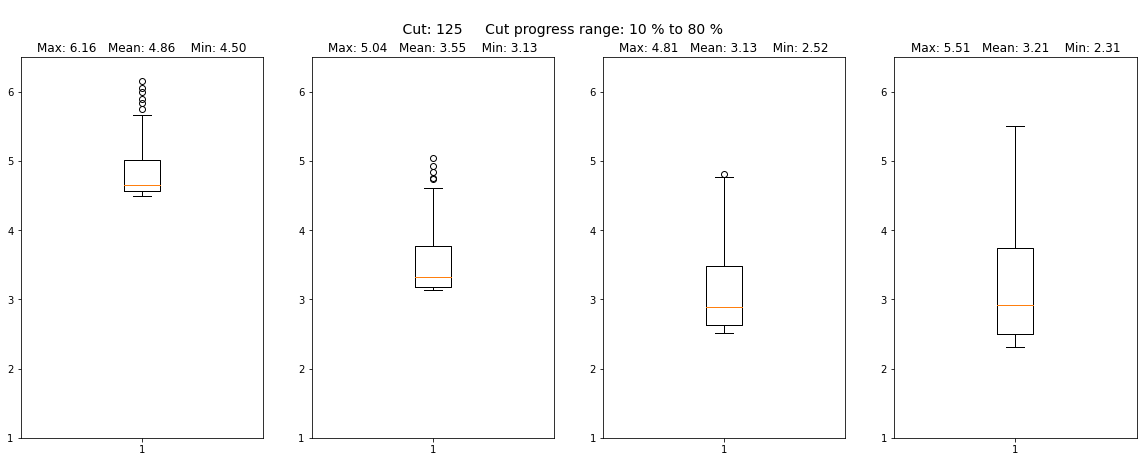

In [31]:
# Main for boxplot of each-sensors data on a single graph
# under design on 2021/02/19

# Set the file of kappa data
bow_file, kappa_file= Bow_Kappa_files(cut_name, my_path)

# Set useful sheet names
#sheet_params = "Params"
sheet_kappa = "Kappa"

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 70  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max
    
    # Figure settings
    nb_col = 5 * sensors_nbr
    nb_lin = 7 * 1
    fig = plt.figure(figsize=(nb_col,nb_lin ))
    plt.suptitle(f'\n Cut: {cut_name}     Cut progress range: {cut_min_interv} % to {cut_max_interv} %',fontsize=14) 
    
    for sensor in range(1,sensors_nbr + 1):
        
        # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function         
        dkappa_flatten = Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)        
        # Subplot settings for boxplot plot
        plt.subplot(1,sensors_nbr,sensor)

        # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
        # Statistics computation
        k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
        k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
        k_min = "{:5.2f}".format(np.min(dkappa_flatten))
        plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
        Kappa_bbox(dkappa_flatten, eff_min, eff_max)
        
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should lower than ' + str(num_max))